In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from distutils.dir_util import copy_tree, remove_tree
from random import randint
from PIL import Image
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.utils.vis_utils import plot_model



In [2]:
root_dir ='./'
base_dir = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/'
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"
if os.path.exists(work_dir):
    remove_tree(work_dir)
os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))    


Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [3]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [4]:
ZOOM_RANGE = [0.99,1.01]
BRIGHT_RANGE = [0.8,1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
work_dr = IDG(rescale=1./255, brightness_range = BRIGHT_RANGE, zoom_range = ZOOM_RANGE, data_format = DATA_FORMAT,
            fill_mode = FILL_MODE, horizontal_flip = HORZ_FLIP)

In [5]:
train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


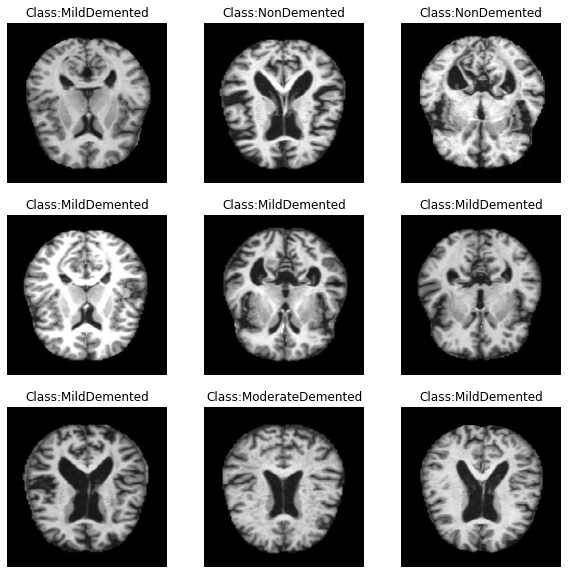

In [6]:
def show_images(generator, y_pred=None):
    labels = dict(zip([0,1,2,3], CLASSES))
    x,y = generator.next()
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3,3,i+1)
            idx = randint(0,6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
show_images(train_data_gen)
        
        


In [7]:
train_data, train_labels = train_data_gen.next()
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [8]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [9]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [11]:
ResNet152V2_model = ResNet152V2(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

234553344/234545216 [==============================] - 2s 0us/step


In [13]:
for layer in ResNet152V2_model.layers:
    layer.trainable=False

In [14]:
custom_ResNet152V2_model = Sequential([
        ResNet152V2_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "ResNet152V2_cnn_model")

In [15]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True      
my_callback = MyCallback()
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [17]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback, rop_callback]
    
custom_ResNet152V2_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_ResNet152V2_model.summary()

Model: "ResNet152V2_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 6, 6, 2048)        58331648  
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)     

In [18]:
EPOCHS = 100
history = custom_ResNet152V2_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), 
                                 callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/100
256/256 [==============================] - 47s 137ms/step - loss: 1.5592 - acc: 0.3586 - auc: 0.6214 - f1_score: 0.3546 - val_loss: 0.7995 - val_acc: 0.6270 - val_auc: 0.8806 - val_f1_score: 0.6023
Epoch 2/100
256/256 [==============================] - 32s 125ms/step - loss: 0.9375 - acc: 0.5696 - auc: 0.8383 - f1_score: 0.5628 - val_loss: 0.6502 - val_acc: 0.6909 - val_auc: 0.9203 - val_f1_score: 0.6837
Epoch 3/100
256/256 [==============================] - 32s 125ms/step - loss: 0.7819 - acc: 0.6470 - auc: 0.8877 - f1_score: 0.6419 - val_loss: 0.5871 - val_acc: 0.7188 - val_auc: 0.9333 - val_f1_score: 0.7178
Epoch 4/100
256/256 [==============================] - 32s 125ms/step - loss: 0.7192 - acc: 0.6783 - auc: 0.9065 - f1_score: 0.6800 - val_loss: 0.5361 - val_acc: 0.7642 - val_auc: 0.9468 - val_f1_score: 0.7644
Epoch 5/100
256/256 [==============================] - 32s 124ms/step - loss: 0.6393 - acc: 0.7261 - auc: 0.9273 - f1_score: 0.7249 - val_loss: 0.5112 - val_acc

In [20]:
test_scores = custom_ResNet152V2_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 8s 99ms/step - loss: 0.2277 - acc: 0.9148 - auc: 0.9904 - f1_score: 0.9150
Testing Accuracy: 91.48%


In [22]:
pred_lab = custom_ResNet152V2_model.predict(test_data)

In [23]:
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_lab:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_lab, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.94      0.96      0.95       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.91      0.81      0.86       662
ModerateDemented       0.82      0.90      0.86       624

       micro avg       0.91      0.91      0.91      2560
       macro avg       0.92      0.92      0.91      2560
    weighted avg       0.92      0.91      0.91      2560
     samples avg       0.91      0.91      0.91      2560



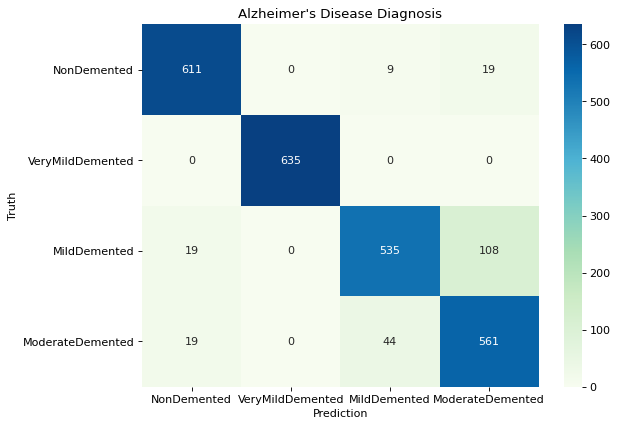

<Figure size 432x288 with 0 Axes>

In [24]:
pred_ls = np.argmax(pred_lab, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='GnBu', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)
plt.savefig(work_dir+'custom_ResNet152V2_confusion_final.png')



In [25]:
custom_ResNet152V2_model_dir = work_dir + "custom_ResNet152V2_model"
custom_ResNet152V2_model.save(custom_ResNet152V2_model_dir, save_format='h5')
os.listdir(work_dir)

['custom_ResNet152V2_model',
 'MildDemented',
 'custom_ResNet152V2_confusion_final.png',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented']

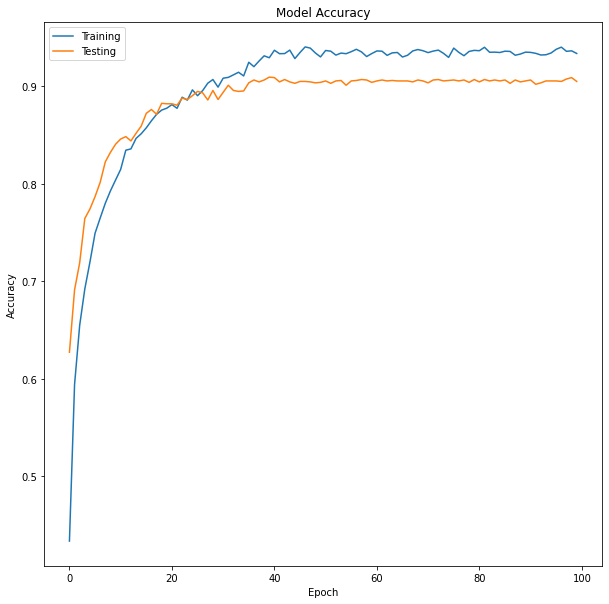

In [26]:
plt.figure(figsize=(10,10))
 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
 
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
 
plt.legend(['Training', 'Testing'])
plt.savefig(work_dir+'custom_ResNet152V2_accuracy_final.png')
plt.show()

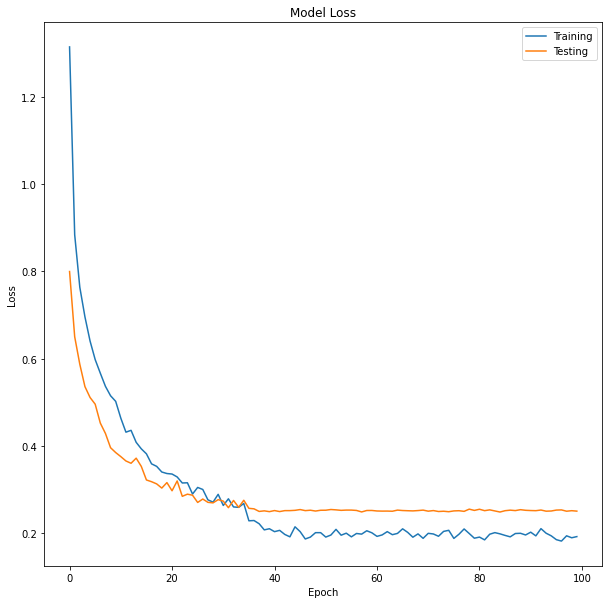

In [27]:
plt.figure(figsize=(10,10))
 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
 
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
 
plt.legend(['Training', 'Testing'])
plt.savefig(work_dir+'custom_ResNet152V2_loss_final.png')
plt.show()

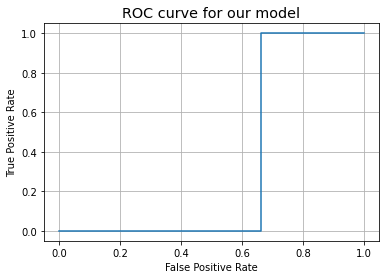

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
pred_ls = np.argmax(pred_lab, axis=1)
test_ls = np.argmax(test_labels, axis=1)
fpr, tpr, thresholds = roc_curve(test_ls, pred_ls,pos_label=True)
# auc = roc_auc_score(test_ls, pred_ls)
# print('AUC: %.3f' % auc)
plt.plot(fpr, tpr)
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig(work_dir+'custom_ResNet152V2_ROC_final.png')
plt.grid(True)


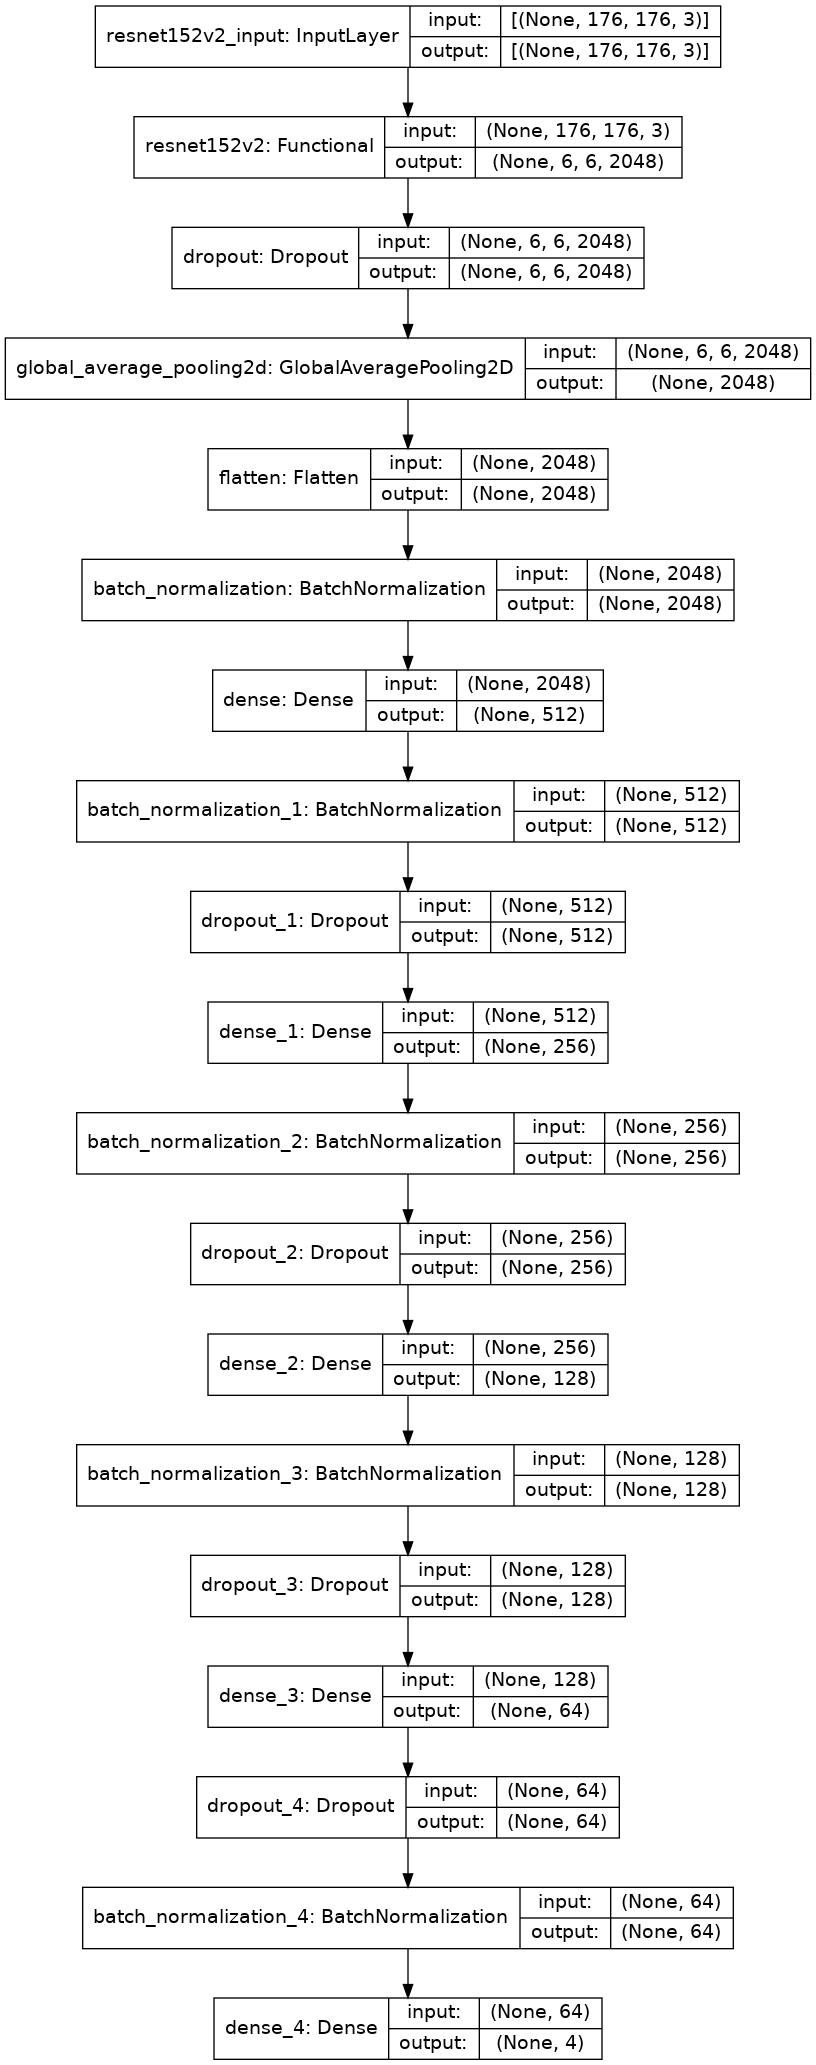

In [29]:
pretrained_model = custom_ResNet152V2_model
plot_model(pretrained_model, to_file=work_dir + "custom_ResNet152V2_architecture_plot.png", show_shapes=True, show_layer_names=True)
